# 데이터 다루기

## 1. 데이터 탐색하기
해결하려는 문제를 파악했고 관련된 데이터를 받았다면 바로 어떠한 모델을 만들어서 해답을 찾고자 하는 욕구가 생길 것이다. 하지만 이러한 욕구를 참고, 가장 먼저 해야 할 일은 데이터를 탐색하는 것이다.

### 1.1. 차원 데이터 탐색하기
데이터의 형태가 가장 간단한 경우는 단순히 숫자로만 구성된 1차원 데이터가 주어졌을 때다. 사용자가 하루 평균 사이트에서 보내는 시간이나 데이터 과학 관련 튜토리얼 비디오가 재생된 횟수 혹은 갖고 있는 데이터 과학 책 쪽수가 대표적인 예시이다. 당연히 가장 먼저 __요약 통계치(summary statistics)__ 를 계산해야 한다. 특히 데이터의 **개수, 최솟값, 최댓값, 평균, 표준편차**에 관해 알아볼 필요가 있다. 하지만 요약 통계치가 무의미한 경우도 있다. 이럴 때는 범위를 몇 개의 구간으로 나누고 각 가구간 안의 데이터 개수를 살펴보는 **히스토그램**을 만들자.

In [3]:
from typing import List, Dict
from collections import Counter
import math

import matplotlib.pyplot as plt

# 각 데이터를 bucket_size의 배수에 해당하는 구간에 취치시킨다.
def bucketize(point: float, bucket_size: float) -> float:
    return bucket_size * math.floor(point / bucket_size)

# 구간을 생성하고 각 구간 안의 데이터 개수를 계산해 준다.
def make_histogram(points: List[float], bucket_size: float) -> Dict[float, int]:
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points: List[float], bucket_size: float, title: str=""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)

먼저 아래 두 가지 데이터를 살펴보자. 두 데이터 모두 평균이 대략 0, 표준편차가 대략 58이지만 굉장히 다른 모양의 분포를 띈다. 

In [8]:
import random

def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

def inverse_normal_cdf(p: float,
                       mu: float = 0,
                       sigma: float = 1,
                       tolerance: float = 0.00001) -> float:
    """Find approximate inverse using binary search"""

    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    low_z = -10.0                      # normal_cdf(-10) is (very close to) 0
    hi_z  =  10.0                      # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # Consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the cdf's value there
        if mid_p < p:
            low_z = mid_z              # Midpoint too low, search above it
        else:
            hi_z = mid_z               # Midpoint too high, search below it

    return mid_z

In [12]:
random.seed(0)

# -100과 100 사이의 분포
uniform = [200 * random.random() - 100 for _ in range(10000)]

# 평균이 0이고 표준편차가 57인 정규분포
normal = [57 * inverse_normal_cdf(random.random()) for _ in range(10000)]

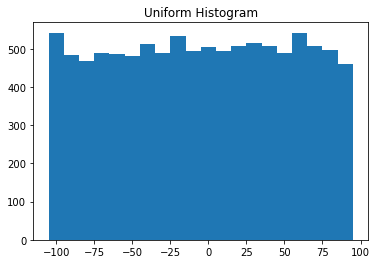

In [10]:
# 균등 분포의 모양
plot_histogram(uniform, 10, "Uniform Histogram")

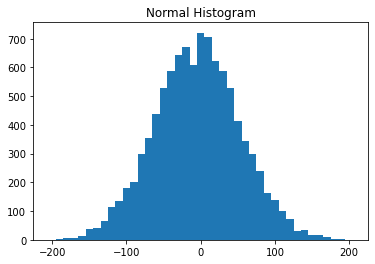

In [11]:
# 정규 분포의 모양
plot_histogram(normal, 10, "Normal Histogram")

### 1.2차원 데이터 탐색하기
이제 2차원 데이터가 주어졌다고 해보자. 사용자가 하루 평균 사이트에서 보내는 시간뿐 아니라 사용자의 데이터 과학 경력까지 주어졌다고 해보자. 물론 각 변수를 따로 살펴볼 수도 있지만 두 변수가 2차원 공간상에서 어떻게 분포를 이루는지 살펴보는 것도 의미가 있다. 예를 들어 다음과 같은 데이터가 있다고 해보자

In [21]:
# 표준정규분포를 따르는 임의의 데이터를 반환
def random_normal() -> float:
    return inverse_normal_cdf(random.random())
    
xs = [random_normal() for _ in range(1000)]
ys1 = [ x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() /2 for x in xs]

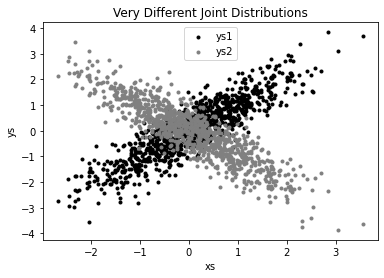

In [22]:
plt.scatter(xs, ys1, marker='.', color="black", label='ys1')
plt.scatter(xs, ys2, marker='.', color='gray', label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title("Very Different Joint Distributions")
plt.show()

### 1.3. 다차원 데이터 탐색하기

다차원 데이터의 경우 각 차원이 서로 어떻게 연관되어 있는지 살펴볼 수 있다. 가장 간편한 방법은 상관관계 행렬을 살펴보는 것이다. 상관관계 행렬의 i번째 행과 j번째 열에 해당하는 값은 i번째 차원과 j번째 차원의 상관관계를 나타낸다. 이때, 차원의 수가 많지 않다면 __산포도 행렬(scatterplot matrix)__ 을 이용해서 각 차원의 쌍별로 산포도를 시각화할 수 있다. plt.subplots를 사용하면 차트 안에 하위 차트를 생성할 수 있다. plt.subplots에 행과 열을 입력하는 figure 객체와 2차원 axes 객체를 반환해 준다.

In [23]:
from typing import Callable

Matrix = List[List[float]]
Vector = List[float]

def make_matrix(num_rows: int,
                num_cols: int,
                entry_fn: Callable[[int, int], float]) -> Matrix:
    """
    Returns a num_rows x num_cols matrix
    whose (i,j)-th entry is entry_fn(i, j)
    """
    return [[entry_fn(i, j)             # given i, create a list
             for j in range(num_cols)]  #   [entry_fn(i, 0), ... ]
            for i in range(num_rows)]   # create one list for each i

In [24]:
# (i, j)번째 항목이 data[i]와 data[j]의 상관관계를 나타내는 len(data) * len(data) 행렬을 반환
def correlation_matrix(data: List[Vector]) -> Matrix:
    def correlation_ij(i: int, j: int) -> float:
        return correlation(data[i], data[j])
    return make_matix(len(data), len(data), correlation_ij)

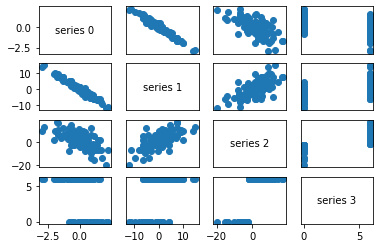

In [28]:
def random_row() -> List[float]:
   row = [0.0, 0, 0, 0]
   row[0] = random_normal()
   row[1] = -5 * row[0] + random_normal()
   row[2] = row[0] + row[1] + 5 * random_normal()
   row[3] = 6 if row[2] > -2 else 0
   return row

random.seed(0)
corr_rows = [random_row() for _ in range(100)]
corr_data = [list(col) for col in zip(*corr_rows)]
num_vectors = len(corr_data)
fig, ax = plt.subplots(num_vectors, num_vectors)

for i in range(num_vectors):
    for j in range(num_vectors):
        # x축은 j번째 열을, y축은 i번째 행을 나타내는 산포도
        if i != j: ax[i][j].scatter(corr_data[j], corr_data[i])
        # 만약 i == j, series라는 제목 출력
        else: ax[i][j].annotate("series " + str(i), (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
        
        # 왼쪽과 밑에 위치한 차트에만 축 레이블 명시
        if i < num_vectors - 1: ax[i][j].xaxis.set_visible(False)
        if j > 0: ax[i][j].yaxis.set_visible(False)
                
# 밑에서 가장 오른쪽 그리고 왼쪽에서 가장 위에 위치한 차트 안에는 문자열만 있기 때문에 축 레이블을 고정
ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())
plt.show()

## 2. NamedTuple 사용하기
데이터는 흔히 딕셔너리로 표현되지만 이는 여러 이유로 이상적이지 않다. 딕셔너리는 약간의 오버헤드가 있는 비효율적인 표현 방식이기에 많은 수의 주가 정보가 있다면 필요 이상의 많은 메모리를 차지할 것이다. 더불어 데이터에 접근할 때 오류를 일으키기 쉽다는 단점이 있다. 또한 다양한 타입의 값을 들고 있는 딕셔너리를 표현할 수 있는 좋은 어노테이션 방법이 없다. 따라서 대안으로 파이썬은 튜플(tuple)과 비슷하지만 명명할 수 있는 공간을 지닌 **namedtuple** 모듈을 제공한다. 튜플처럼 namedtuple 또한 생성된 이후 값을 수정할 수 없다.

In [32]:
from collections import namedtuple
import datetime

StockPrice = namedtuple('stockPrice', ['symbol', 'date', 'closing_price'])
price = StockPrice('MSFT', datetime.date(2018, 12, 14), 106.03)

assert price.symbol == "MSFT"
assert price.closing_price == 106.03
print(price)

stockPrice(symbol='MSFT', date=datetime.date(2018, 12, 14), closing_price=106.03)


namedtuple은 좋은 대안이지만 아직 타입 어노테이션 문제를 해결하지 않았다. 이 문제는 타입을 지닌 NamedTuple을 사용하여 해결할 수 있다.

In [33]:
from typing import NamedTuple

class stockPrice(NamedTuple):
    symbol: str
    date: datetime.date
    closing_price: float
    
    def is_high_tech(self) -> bool:
        return self.symbol in ["MSFT", 'GOOG', 'FB', 'AMZN', "AAPL"]
    
price = stockPrice("MSFT", datetime.date(2018, 12, 14), 106.03)

assert price.symbol == "MSFT"
assert price.closing_price == 106.03
assert price.is_high_tech()
print(price)

stockPrice(symbol='MSFT', date=datetime.date(2018, 12, 14), closing_price=106.03)


## 3. Dataclasses
Dataclasses는 마치 NamedTuple의 가변적인 버전처럼 동작한다. 문법은 NamedTuple과 매우 유사하다. 하지만 베이스 클래스(base class)에서 상속을 받는 대신 데코레이터(decorator)를 사용한다.

In [66]:
from dataclasses import dataclass

@dataclass
class StockPrice2:
    symbol: str
    date: datetime.date
    closing_price: float
    
    def is_high_tech(self) -> bool:
        return self.symbol in ["MSFT", 'GOOG', 'FB', 'AMZN', "AAPL"]

price2 = StockPrice2("MSFT", datetime.date(2018, 12, 14), 106.03)

assert price2.symbol == "MSFT"
assert price2.closing_price == 106.03
assert price2.is_high_tech()
print(price2)

StockPrice2(symbol='MSFT', date=datetime.date(2018, 12, 14), closing_price=106.03)


이미 언급했다시피 NamedTuple과 dataclasses의 가장 큰 차이는 **dataclasses의 인스턴스 값을 수정할 수 있다는 점이다.**

In [67]:
price2.closing_price = round(price2.closing_price / 2, 2)
assert price2.closing_price == 53.02
print(price2)

price2.closing_price = 75
assert price2.closing_price == 75
print(price2)

StockPrice2(symbol='MSFT', date=datetime.date(2018, 12, 14), closing_price=53.02)
StockPrice2(symbol='MSFT', date=datetime.date(2018, 12, 14), closing_price=75)


# 4. 정제하고 합치기
이 부분은 책에서 너무 간단하게 다루고 있으며 대중적이지 않은 방식으로 정규화를 진행하여 생략하였다. 차후 정규화만 다룬 내용을 업데이트 할 계획이다.

## 5. 데이터 처리

## 6. 척도 조절

## 7. tqdm

## 8. 차원 축소